In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster
import random

random.seed(42)
np.random.seed(42)

In [2]:
HOME = "/home/ec2-user/np-clinical-trials"
full_fingerprints_df = pd.read_csv(f"{HOME}/data/full_fingerprints_df.parquet")

In [3]:
def process_subset(
    input_data,
    subset_column="source",
    current_subset="",
    smiles_column="SMILES",
    sampling=False,
):
    subset = input_data[input_data[subset_column] == current_subset]
    if sampling == True:
        subset = subset.sample(100000).reset_index(drop=True)
    scaled_subset = pd.DataFrame(
        StandardScaler().fit_transform(
            subset.drop(columns=[subset_column, smiles_column])
            .replace([np.inf, -np.inf], np.nan)
            .fillna(0)
        ),
        columns=subset.drop(columns=[subset_column, smiles_column]).columns,
        index=subset.index,
    )
    ids = subset[[smiles_column, subset_column]]
    return scaled_subset, ids

In [4]:
full_fingerprints_df["source"].value_counts()

source
COCONUT    407270
OCHEM      275132
DDS         50063
Name: count, dtype: int64

In [5]:
scaled_synthetic, synthetic_ids = process_subset(
    full_fingerprints_df, current_subset="DDS"
)
scaled_coconut, coconut_ids = process_subset(
    full_fingerprints_df, current_subset="COCONUT", sampling=True
)

In [6]:
def cluster_size_driven_hierarchical_clustering(input_data, minimum_cluster_size=10):
    """
    Perform hierarchical clustering on the input data and return the clusters where each cluster has more than minimum_cluster_size elements.
    :param input_data: The input data to cluster
    :param minimum_cluster_size: The minimum number of elements in each cluster
    """
    Z = linkage(input_data, "ward")
    previous_clusters = fcluster(Z, t=1, criterion="maxclust")
    for i in range(2, 100):
        clusters = fcluster(Z, t=i, criterion="maxclust")
        unique_clusters = np.unique(clusters)
        unique_clusters_counts = {
            i: len(np.where(clusters == i)[0]) for i in unique_clusters
        }
        for current_cluster, count in unique_clusters_counts.items():
            if count < minimum_cluster_size:
                print(
                    f"Maximum number of clusters where each has more than {minimum_cluster_size} elements: {np.unique(previous_clusters).shape[0]}"
                )
                return previous_clusters
        previous_clusters = clusters

In [7]:
synthetic_clusters = cluster_size_driven_hierarchical_clustering(scaled_synthetic)

Maximum number of clusters where each has more than 10 elements: 23


In [8]:
coconut_clusters = cluster_size_driven_hierarchical_clustering(scaled_coconut)

Maximum number of clusters where each has more than 10 elements: 31


In [9]:
def grab_random_samples_by_cluster(
    input_ids, cluster_column="", number_of_samples_per_cluster=10
):
    """ """
    random.seed(42)
    cluster_ids = []
    for current_cluster in input_ids[cluster_column].unique():
        cluster_subset = input_ids.loc[input_ids[cluster_column] == current_cluster]
        cluster_indexes = list(cluster_subset.index)
        random.shuffle(cluster_indexes)
        random_indexes = cluster_indexes[0:number_of_samples_per_cluster]
        cluster_ids.append(cluster_subset.loc[random_indexes])

    return pd.concat(cluster_ids, axis=0)

In [10]:
synthetic_ids["cluster"] = synthetic_clusters
coconut_ids["cluster"] = coconut_clusters
subset_synthetic_ids = grab_random_samples_by_cluster(
    synthetic_ids, cluster_column="cluster", number_of_samples_per_cluster=50
)
subset_coconut_ids = grab_random_samples_by_cluster(
    coconut_ids, cluster_column="cluster", number_of_samples_per_cluster=50
)

In [11]:
ids_dictionary = {
    1: "Anticommensal Effect on\n Human Gut Microbiota",
    2: "Blood–brain-barrier penetration",
    3: "Oral Bioavailability",
    4: "AMES Mutagenecity",
    5: "Metabolic Stability",
    6: "Rat Acute LD50",
    7: "Drug-Induced Liver Inhibition",
    8: "HERG Cardiotoxicity",
    9: "Haemolytic Toxicity",
    10: "Myelotoxicity",
    11: "Urinary Toxicity",
    12: "Human Intestinal Absorption",
    13: "Hepatic Steatosis",
    14: "Breast Cancer Resistance Protein Inhibition",
    15: "Drug-Induced Choleostasis",
    16: "Human multidrug and toxin extrusion Inhibition",
    17: "Toxic Myopathy",
    18: "Phospholipidosis",
    19: "Human Bile Salt Export Pump Inhibition",
    20: "Organic anion transporting\n polypeptide 1B1 binding",
    21: "Organic anion transporting\n polypeptide 1B3 binding",
    22: "Organic anion transporting\n polypeptide 2B1 binding",
    23: "Phototoxicity human",
    24: "Phototoxicity in vitro",
    25: "Respiratory Toxicity",
    26: "P-glycoprotein Inhibition",
    27: "P-glycoprotein Substrate",
    28: "Mitochondrial Toxicity",
    29: "Carcinogenecity",
    30: "DMSO Solubility",
    31: "Human Liver Microsomal Stability",
    32: "Human Plasma Protein Binding",
    33: "hERG Liability",
    34: "Organic Cation\n Transporter 2 Inhibition",
    35: "Drug-induced Ototoxicity",
    36: "Rhabdomyolysis",
    37: "T1/2 Human",
    38: "T1/2 Mouse",
    39: "T1/2 Rat",
    40: "Cytotoxicity HepG2",  # "cell line",
    41: "Cytotoxicity NIH 3T3",  # "cell line",
    42: "Cytotoxicity HEK 293",  # "cell line",
    43: "Cytotoxicity CRL-7250",  # "cell line",
    44: "Cytotoxicity HaCat",  # "cell line",
    45: "CYP450 1A2 Inhibition",
    46: "CYP450 2C19 Inhibition",
    47: "CYP450 2C9 Inhibition",
    48: "CYP450 2D6 Inhibition",
    49: "CYP450 3A4 Inhibition",
    50: "pKa dissociation constant",
    51: "logD Distribution \ncoefficient (pH 7.4)",
    52: "logS",
    53: "Drug affinity to human serum albumin",
    54: "MDCK permeability",
    55: "50% hemolytic dose",
    56: "Skin penetration",
    57: "CYP450 2C8 Inhibition",
    58: "Aqueous Solubility",  # "(in phosphate saline buffer)",
}

In [12]:
coconut_folder = "/home/ec2-user/np-clinical-trials/fpadmet_results/COCONUT"
dds_folder = "/home/ec2-user/np-clinical-trials/fpadmet_results/DDS"

In [13]:
def process_data(input_folder, threshold=0.5, subset_SMILES=[]):
    """
    While the confidence provides a measure of how likely a prediction is compared to all other possible classifications, the credibility measure (equal to the highest p-value of any one of the possible classifications being the true label) provides an indication of how good the training set is for classifying the given example.
    """
    results_list, names_list = [], []
    batch_dictionary = {}
    for files in os.listdir(input_folder):

        if not files.endswith("predicted.txt"):
            continue

        ids_file = files.replace("predicted", "fps")
        opened_ids = pd.read_csv(
            os.path.join(input_folder, ids_file), sep="\s+", header=None
        )
        opened_ids.columns = ["SMILES", "id"]
        usable_ids = opened_ids[opened_ids["SMILES"].isin(subset_SMILES)]["id"].tolist()
        toxicity_name = ids_dictionary[int(files.split("_")[1].split(".")[0])]
        try:
            opened_data = pd.read_csv(os.path.join(input_folder, files), sep="\s+")
            opened_data = opened_data.loc[usable_ids]
            opened_data = opened_data[opened_data["Credibility"] > threshold][
                "Predicted"
            ]

            if toxicity_name in batch_dictionary:
                batch_dictionary[toxicity_name] = pd.concat(
                    [batch_dictionary[toxicity_name], opened_data], axis=0
                )
            else:
                batch_dictionary[toxicity_name] = opened_data
        except Exception as e:
            # print(f"Failed to process {files} with error {e}")
            continue

    for key in batch_dictionary:
        results_list.append(batch_dictionary[key])
        names_list.append(key)
    all_metrics = pd.concat(results_list, axis=1)
    all_metrics.columns = names_list
    return all_metrics, names_list

In [14]:
coconut_data, coconut_columns = process_data(
    coconut_folder, threshold=0.5, subset_SMILES=subset_coconut_ids["SMILES"].tolist()
)

In [15]:
synthethic_data, synthetic_columns = process_data(
    dds_folder, threshold=0.5, subset_SMILES=subset_synthetic_ids["SMILES"].tolist()
)

In [16]:
non_case_relevant_columns = [
    "T1/2 Human",
    "T1/2 Mouse",
    "T1/2 Rat",
    "Rat Acute LD50",
    "Human Plasma Protein Binding",
    "Anticommensal Effect on\n Human Gut Microbiota",
    "Blood-brain-barrier penetration",
    "P-glycoprotein Inhibition",
    "P-glycoprotein Substrate",
    "DMSO Solubility",
    "Breast Cancer Resistance Protein Inhibition",
    "Organic anion transporting\n polypeptide 1B1 binding",
    "Organic anion transporting\n polypeptide 1B3 binding",
    "Organic anion transporting\n polypeptide 2B1 binding",
    "Organic anion transporting\n polypeptide 3B1 binding",
    "Metabolic Stability",
    "AMES Mutagenecity",
    "Oral Bioavailability",
    "Human intestinal absortion",
    "Organic Cation\n Transporter 2 Inhibition",
]

In [17]:
usable_columns = [x for x in coconut_columns if x not in non_case_relevant_columns]

In [21]:
converter_dictionary = {
    "N": "Negative",
    "P": "Positive",
    "Yes": "Positive",
    "No": "Negative",
    "Negative": "Negative",
    "Positive": "Positive",
    "negative": "Negative",
    "positive": "Positive",
    "no": "negative",
    "yes": "positive",
    "Carcinogen": "Positive",
    "NonCarcinogen": "Negative",
    "Inhibitor": "Positive",
    "NonInhibitor": "Negative",
    "Noninhibitor": "Negative",
    "Insoluble": "Negative",
    "Soluble": "Positive",
    "Active": "Positive",
    "Inactive": "Negative",
    "active": "Positive",
    "inactive": "Negative",
    "Blocker": "Positive",
    "NonBlocker": "Negative",
    "Stable": "Positive",
    "Unstable": "Negative",
    "Moderate": "Negative",
}
labels = []  # Collect legend labels

positive_columns = []
to_remove_columns = []
variable_count = 0
for current_column in usable_columns:
    subset_coconut_data = coconut_data.dropna(subset=[current_column])
    subset_coconut_data[current_column] = (
        subset_coconut_data[current_column]
        .map(converter_dictionary)
        .fillna(subset_coconut_data[current_column])
    )
    coconut_subset = subset_coconut_data[current_column].value_counts(normalize=True)
    coconut_absolute_subset = subset_coconut_data[current_column].value_counts()

    subset_synthethic_data = synthethic_data.dropna(subset=[current_column])
    subset_synthethic_data[current_column] = (
        subset_synthethic_data[current_column]
        .map(converter_dictionary)
        .fillna(subset_synthethic_data[current_column])
    )

    synthetic_subset = subset_synthethic_data[current_column].value_counts(
        normalize=True
    )
    synthetic_absolute_subset = subset_synthethic_data[current_column].value_counts()

    combined_subset = pd.concat(
        [coconut_subset, synthetic_subset], keys=["COCONUT", "DDS"], axis=1
    )
    if list(combined_subset.index) == ["negative", "positive"]:
        combined_subset.index = ["Negative", "Positive"]
    positive_columns.append(combined_subset.loc["Positive"])

positive_dataframe = pd.concat(positive_columns, axis=1)
positive_dataframe.columns = usable_columns

/tmp/ipykernel_29602/3603835146.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_coconut_data[current_column] = (
/tmp/ipykernel_29602/3603835146.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_synthethic_data[current_column] = (
/tmp/ipykernel_29602/3603835146.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [19]:
positive_dataframe

,Blood–brain-barrier penetration,HERG Cardiotoxicity,Drug-Induced Liver Inhibition,Urinary Toxicity,Haemolytic Toxicity,Myelotoxicity,Human Intestinal Absorption,Hepatic Steatosis,Human multidrug and toxin extrusion Inhibition,Drug-Induced Choleostasis,...,CYP450 2C19 Inhibition,Cytotoxicity CRL-7250,CYP450 2D6 Inhibition,Cytotoxicity HaCat,Cytotoxicity HEK 293,CYP450 3A4 Inhibition,Cytotoxicity NIH 3T3,Phototoxicity in vitro,CYP450 1A2 Inhibition,CYP450 2C9 Inhibition
COCONUT,0.138889,0.005405,0.462810,0.110974,0.153846,0.425558,0.508197,0.068437,0.018946,0.199791,...,0.118072,0.016461,0.067146,0.011583,0.101408,0.114192,0.119241,0.062500,0.048995,0.146429
DSS,0.958333,0.017241,0.963415,0.154639,1.000000,0.618267,0.995902,0.227273,0.002990,0.176752,...,0.423841,0.015385,0.142029,0.013393,0.055556,0.177326,0.084559,0.267961,0.158120,0.314685


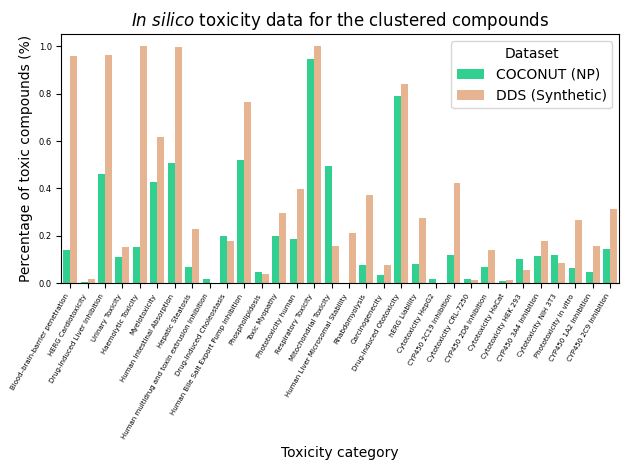

In [22]:
# Reshape the DataFrame for seaborn
reshaped_dataframe = positive_dataframe.reset_index().melt(
    id_vars="index", var_name="Toxicity Category", value_name="Percentage"
)

# Set the color palette
colors = ["#16EB96", "#F4B183"]
renamed_categories = {
    "COCONUT": "COCONUT (NP)",
    "DDS": "DDS (Synthetic)",
}
reshaped_dataframe["index"] = reshaped_dataframe["index"].map(renamed_categories)
reshaped_dataframe = reshaped_dataframe.rename(
    columns={"Toxicity Category": "Toxicity category"}
)
# Plotting the bar plot using seaborn
ax = sns.barplot(
    x="Toxicity category",
    y="Percentage",
    hue="index",
    data=reshaped_dataframe,
    palette=colors,
)

# Adding labels and title
ax.set_ylabel("Percentage of toxic compounds (%)")
ax.set_title("$\it{In}$ $\it{silico}$ toxicity data for the clustered compounds")

# Adding legend
ax.legend(title="Dataset")

# Rotate x-axis labels
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=60, horizontalalignment="right", fontsize=5
)

# Change yticks size
ax.tick_params(axis="y", labelsize=6)

# Adjust layout for better alignment
plt.tight_layout()

plt.savefig("figure4B.png", format="png", dpi=600)

# Show the plot
plt.show()